# IEOR4501 Final Project
#### Zhengyi Zhu (zz2875), Binghao Guo (bg2781), Mike Cellini (mjc2328)

## Project setup

In [1]:
import math
import random
import datetime
import os
from datetime import datetime, timedelta
import re

import bs4
import requests
import pyarrow.parquet as pq

import sqlite3
import sqlalchemy as db

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_DATA_DIR = "taxi_data"

TAXI_ZONES_DIR = "taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"

UBER_CSV = "uber_rides_sample.csv"
WEATHER_CSV_DIR = "weather"

# random seed for reproducibility
random.seed(1)

# coordinate reference system
CRS = 4326

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [3]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

# Part I: Data Preprocessing

## Load Taxi Zones

In [4]:
# get taxi zones data as a zip file
def get_taxi_zones_zip():
    TAXI_ZONE_URL = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip"
    try: # first check whether the file already exists
        with open("taxi_zones.zip", "r") as f:
            pass
    except: # if the file doesn't exist, then download and save the zip file
        response = requests.get(TAXI_ZONE_URL)
        with open("taxi_zones.zip", "wb") as f:
            f.write(response.content)
    return

In [5]:
# download taxizones.zip from url using requests, and manually unzip the files
get_taxi_zones_zip()

In [6]:
# load taxi_zones shapefile using geopandas
def load_taxi_zones(shapefile):
    taxi_zones_shapefile = gpd.read_file(shapefile)
    return taxi_zones_shapefile

In [8]:
# load and save taxi_zones shapefile in "loaded_taxi_zones"
loaded_taxi_zones = load_taxi_zones(TAXI_ZONES_SHAPEFILE)

In [8]:
# check loaded_taxi_zones
print(loaded_taxi_zones.shape)
loaded_taxi_zones.head()

(263, 7)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


In [9]:
def add_coords_for_taxi_zones(loaded_taxi_zones):
    geo_col = loaded_taxi_zones["geometry"].to_crs(4326)
    loaded_taxi_zones["latitude"] = geo_col.centroid.y
    loaded_taxi_zones["longitude"] = geo_col.centroid.x
    return loaded_taxi_zones

In [10]:
# add latitude and longitude columns to loaded_taxi_zones, then show the top lines
loaded_taxi_zones = add_coords_for_taxi_zones(loaded_taxi_zones)

/var/folders/5z/n8xgv02j4v15tvg7n0p73xb00000gn/T/ipykernel_40059/3944803749.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  loaded_taxi_zones["latitude"] = geo_col.centroid.y
/var/folders/5z/n8xgv02j4v15tvg7n0p73xb00000gn/T/ipykernel_40059/3944803749.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  loaded_taxi_zones["longitude"] = geo_col.centroid.x


In [11]:
# select relevant columns, drop duplicate columns
loaded_taxi_zones = loaded_taxi_zones[["LocationID", "latitude", "longitude"]]
loaded_taxi_zones.drop_duplicates(subset = ["LocationID"], inplace = True)
loaded_taxi_zones.sort_values(by = ["LocationID"], inplace = True)
loaded_taxi_zones.reset_index(drop = True, inplace = True)

In [12]:
# check cleaned loaded_taxi_zones
print(loaded_taxi_zones.shape)
loaded_taxi_zones.head()

(260, 3)


,LocationID,latitude,longitude
0,1,40.691831,-74.174000
1,2,40.616745,-73.831299
2,3,40.864474,-73.847422
3,4,40.723752,-73.976968
4,5,40.552659,-74.188484


In [13]:
# compute latitude & longtitude from zone id
def lookup_coords_for_taxi_zone_id(zone_loc_id):
    rows = loaded_taxi_zones[loaded_taxi_zones["LocationID"] == zone_loc_id]
    lon = rows["longitude"].mean()
    lat = rows["latitude"].mean()
    return (lat, lon)

## Calculate distance

In [14]:
# calculate distance with start and end location coords
def calculate_distance_with_coords(from_coord, to_coord):
    d2 = (from_coord[0] - to_coord[0])**2 + (from_coord[1] - to_coord[1])**2
    d = math.sqrt(d2)
    return d

In [15]:
# append "distance" column to dataframe
def add_distance_column(dataframe):
    dt_sub = dataframe[["start_lat", "start_lon", "end_lat", "end_lon"]]
    d = dt_sub.apply(lambda x: calculate_distance_with_coords(tuple([x["start_lat"], x["start_lon"]]), \
                                                              tuple([x["end_lat"], x["end_lon"]])), \
                     axis=1)
    dataframe["distance"] = d
    return dataframe

## Auxiliary functions to help clean data

A __"valid" month__ should be within __2009-01__ to __2015-06__. 

In [16]:
# auxiliary function to check whether the given year and month is within range
def isValidYM(yr, m): 
    valid = False
    if (yr>=2009) & (yr<=2014):
        if (m>=1) & (m<=12):
            valid = True
    if (yr==2015):
        if (m>=1) & (m<=6):
            valid = True
    return valid

A __"valid" trip__ should satisfy the following requirements:
1. start_location and end_location are __different__. (Otherwise, the trip distance is 0. )
2. start_location and end_location are __within the range of New York__. 

In [17]:
# auxiliary function to check whether the given trip is valid with start and end location coords
def isValidTrip_coords(from_coord, to_coord):
    valid = False
    
    min_lat = NEW_YORK_BOX_COORDS[0][0]
    min_lon = NEW_YORK_BOX_COORDS[0][1]
    max_lat = NEW_YORK_BOX_COORDS[1][0]
    max_lon = NEW_YORK_BOX_COORDS[1][1]
    
    if ((from_coord[0] >= min_lat) & (from_coord[0] <= max_lat) \
        & (to_coord[0] >= min_lat) & (to_coord[0] <= max_lat) \
        & (from_coord[1] >= min_lon) & (from_coord[1] <= max_lon) \
        & (to_coord[1] >= min_lon) & (to_coord[1] <= max_lon)): \
        valid = True

    return valid

## Process Uber Data

In [18]:
# load and clean uber data
def load_and_clean_uber_data(csv_file):
    # load data
    # remove the first 2 columns since they are useless ids and datetime we have as another column
    uber = pd.read_csv(csv_file).iloc[:, 2:]
    
    # remove trips with unrealistic fare_amount and passenger_count 
    uber = uber[(uber["fare_amount"] > 0) & (uber["passenger_count"] < 8) & (uber["passenger_count"] >= 1)]
    
    # select and rename relevant columns
    uber.columns = [s.lower() for s in uber.columns]
    uber = uber[["pickup_datetime", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]]  
     
    uber.rename(columns={"pickup_datetime": "start_datetime", \
                         "pickup_latitude": "start_lat", \
                         "pickup_longitude": "start_lon", \
                         "dropoff_latitude": "end_lat", \
                         "dropoff_longitude": "end_lon"},
               inplace=True)
    
    # format datetime as string
    uber["start_datetime"] = [x[:-4] for x in uber["start_datetime"]]
    
    # round longitude & latitude to 6 decimals
    cols = ["start_lat", "start_lon", "end_lat", "end_lon"]
    uber[cols] = uber[cols].round(6)
    
    # select trips in the valid New York range
    # select valid trips
    dt_sub = uber[["start_lat", "start_lon", "end_lat", "end_lon"]]
    v = dt_sub.apply(lambda x: isValidTrip_coords(tuple([x["start_lat"], x["start_lon"]]), \
                                                  tuple([x["end_lat"], x["end_lon"]])), \
                     axis=1)
    uber = uber[v]
    
    # rearrange the columns
    uber = uber[["start_datetime"]+cols]
    
    # sort by datetime, reset index
    uber.sort_values(by=["start_datetime"], inplace=True)
    uber.reset_index(drop=True, inplace=True)
    return uber

In [19]:
# get(load, clean, add distance column) to uber data
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    uber_dataframe = add_distance_column(uber_dataframe)
    return uber_dataframe

In [73]:
# get uber data
uber_data = get_uber_data()

In [74]:
# check uber_data
print(uber_data.shape)
uber_data.head()

(194768, 6)


,start_datetime,start_lat,start_lon,end_lat,end_lon,distance
0,2009-01-01 01:15:22,40.779456,-73.981918,40.771043,-73.957685,0.025652
1,2009-01-01 01:59:17,40.721389,-73.983759,40.687179,-73.994833,0.035958
2,2009-01-01 02:05:03,40.771254,-73.956635,40.749778,-73.991528,0.040972
3,2009-01-01 02:09:13,40.728020,-73.984605,40.776830,-73.955746,0.056703
4,2009-01-01 02:13:41,40.737425,-73.980127,40.726025,-74.009544,0.031549


## Process taxi data 

In [22]:
# get all urls from taxi webpage
def get_all_urls_from_taxi_page(taxi_page):
    response = requests.get(taxi_page)
    html = response.content
    soup = bs4.BeautifulSoup(html, "html.parser")
    all_urls = soup.find_all("a")
    return all_urls

In [23]:
# filter yellow taxi parquet urls
def filter_taxi_parquet_urls(all_urls):
    all_yellow_urls = []
    pattern = r"Yellow\sTaxi\sTrip\sRecords$"
    for a in all_urls:
        if re.search(pattern, a.text):
            all_yellow_urls.append(a["href"])
    return sorted(all_yellow_urls)

In [24]:
# sample, clean, add distance column and finally save csv file for the given month
def sample_clean_addDistance_month(yr, m):
    # load the downloaded parquet file
    data = pq.read_table(f"{TAXI_DATA_DIR}/yellow_tripdata_{yr}_{m}.parquet")
        
    # determine what column names the parquet data of this month uses
    colnames_list = list(["tpep_pickup_datetime", "PULocationID", "DOLocationID"], \
                         ["Trip_Pickup_DateTime", "Start_Lat", "Start_Lon", "End_Lat", "End_Lon"], \
                         ["pickup_datetime", "pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"])
    
    if "tpep_pickup_datetime" in data.column_names:
        colnames_type = 0 
    elif "Trip_Pickup_DateTime" in data.column_names:
        colnames_type = 1
    else:
        colnames_type = 2

    cols = colnames_list[colnames_type]
    
    # sampling & select relevant columns
    sample_idx = random.sample(list(range(len(data))), 200000)
    sample_data = data.take(sample_idx).select(cols)
        
    # convert parquet table to pandas dataframe, throw rows with NA values
    df = sample_data.to_pandas()
            
    if (colnames_type == 0):
        # rename the columns, modify the data types
        # convert timestamp to string
        pattern = r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}"
        ts = df["tpep_pickup_datetime"].apply(lambda x: re.search(pattern, str(x)).group())
        df["start_datetime"] = ts
        
        # convert zone id to coords
        from_coords = df["PULocationID"].apply(lookup_coords_for_taxi_zone_id)
        to_coords = df["DOLocationID"].apply(lookup_coords_for_taxi_zone_id)
            
        start_lat_list, start_lon_list = list(zip(*from_coords))
        end_lat_list, end_lon_list = list(zip(*to_coords))
            
        df["start_lat"] = start_lat_list
        df["start_lon"] = start_lon_list
        df["end_lat"] = end_lat_list
        df["end_lon"] = end_lon_list
        
        df.sort_values(by = ["start_datetime"], inplace = True)
        df.reset_index(drop = True, inplace = True)
        
    if (colnames_type==1):
        # rename the columns
        df.rename(columns = {"Trip_Pickup_DateTime": "start_datetime", \
                             "Start_Lat": "start_lat", \
                             "Start_Lon": "start_lon", \
                             "End_Lat": "end_lat", \
                             "End_Lon": "end_lon"}, 
                 inplace = True)
        
    if (colnames_type==2): 
        # rename the columns
        df.rename(columns = {"pickup_datetime": "start_datetime", \
                             "pickup_latitude": "start_lat", \
                             "pickup_longitude": "start_lon", \
                             "dropoff_latitude": "end_lat", \
                             "dropoff_longitude": "end_lon"}, 
                 inplace = True)
    
    # select rows without NA values
    df = df[~df.isnull()]
    
    # select valid trips
    dt_sub = df[["start_lat", "start_lon", "end_lat", "end_lon"]]
    v = dt_sub.apply(lambda x: isValidTrip_coords(tuple([x["start_lat"], x["start_lon"]]), \
                                                  tuple([x["end_lat"], x["end_lon"]])), \
                     axis = 1)
    df = df[v]
        
    # add distance column
    df = add_distance_column(df)
    df = df[df["distance"] > 0]
    
    # order columns by name
    cols_ordered = ["start_datetime", "start_lat", "start_lon", "end_lat", "end_lon", "distance"]
    df = df[cols_ordered]
    
    # round longitudes, latitudes and distance to 6 decimals
    cols = ["start_lat", "start_lon", "end_lat", "end_lon", "distance"]
    df[cols] = df[cols].round(6)
    
    # sort the dataframe by datetime, reset the index
    df.sort_values(by = ["start_datetime"], inplace = True)
    df.reset_index(drop = True, inplace = True)
    
    # save the monthly dataframe
    df.to_csv(f"{TAXI_DATA_DIR}/yellow_tripdata_{yr}_{m}.csv")
    
    return df

In [25]:
# sample, clean, add distance column and finally save csv file for the given month
def sample_clean_addDistance_month(yr, m):
    # load the downloaded parquet file
    data = pq.read_table(f"{TAXI_DATA_DIR}/yellow_tripdata_{yr}_{m}.parquet")
        
    # determine what column names the parquet data of this month uses
    colnames_list = [["tpep_pickup_datetime", "PULocationID", "DOLocationID", "tip_amount"], \
                     ["Trip_Pickup_DateTime", "Start_Lat", "Start_Lon", "End_Lat", "End_Lon", "Tip_Amt"], \
                     ["pickup_datetime", "pickup_latitude", "pickup_longitude", \
                      "dropoff_latitude", "dropoff_longitude", "tip_amount"]]
    
    if "tpep_pickup_datetime" in data.column_names:
        colnames_type = 0 
    elif "Trip_Pickup_DateTime" in data.column_names:
        colnames_type = 1
    else:
        colnames_type = 2

    cols = colnames_list[colnames_type]
    
    # sampling & select relevant columns
    sample_idx = random.sample(list(range(len(data))), 200000)
    sample_data = data.take(sample_idx).select(cols)
        
    # convert parquet table to pandas dataframe, throw rows with NA values
    df = sample_data.to_pandas()
            
    if (colnames_type == 0):
        # rename the columns, modify the data types
        # convert timestamp to string
        pattern = r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}"
        ts = df["tpep_pickup_datetime"].apply(lambda x: re.search(pattern, str(x)).group())
        df["start_datetime"] = ts
        
        # convert zone id to coords
        from_coords = df["PULocationID"].apply(lookup_coords_for_taxi_zone_id)
        to_coords = df["DOLocationID"].apply(lookup_coords_for_taxi_zone_id)
            
        start_lat_list, start_lon_list = list(zip(*from_coords))
        end_lat_list, end_lon_list = list(zip(*to_coords))
            
        df["start_lat"] = start_lat_list
        df["start_lon"] = start_lon_list
        df["end_lat"] = end_lat_list
        df["end_lon"] = end_lon_list
        
        df.sort_values(by = ["start_datetime"], inplace = True)
        df.reset_index(drop = True, inplace = True)
        
    if (colnames_type==1):
        # rename the columns
        df.rename(columns = {"Trip_Pickup_DateTime": "start_datetime", \
                             "Start_Lat": "start_lat", \
                             "Start_Lon": "start_lon", \
                             "End_Lat": "end_lat", \
                             "End_Lon": "end_lon", \
                             "Tip_Amt": "tip_amount"}, 
                 inplace = True)
        
    if (colnames_type==2): 
        # rename the columns
        df.rename(columns = {"pickup_datetime": "start_datetime", \
                             "pickup_latitude": "start_lat", \
                             "pickup_longitude": "start_lon", \
                             "dropoff_latitude": "end_lat", \
                             "dropoff_longitude": "end_lon"}, 
                 inplace = True)
    
    # select rows without NA values
    df = df[~df.isnull()]
    
    # select valid trips
    dt_sub = df[["start_lat", "start_lon", "end_lat", "end_lon"]]
    v = dt_sub.apply(lambda x: isValidTrip_coords(tuple([x["start_lat"], x["start_lon"]]), \
                                                  tuple([x["end_lat"], x["end_lon"]])), \
                     axis = 1)
    df = df[v]
        
    # add distance column
    df = add_distance_column(df)
    df = df[df["distance"] > 0]
    
    # order columns by name
    cols_ordered = ["start_datetime", "start_lat", "start_lon", "end_lat", "end_lon", "distance", "tip_amount"]
    df = df[cols_ordered]
    
    # round longitudes, latitudes and distance to 6 decimals
    cols = ["start_lat", "start_lon", "end_lat", "end_lon", "distance"]
    df[cols] = df[cols].round(6)
    df["tip_amount"] = df["tip_amount"].round(2)
    
    # sort the dataframe by datetime, reset the index
    df.sort_values(by = ["start_datetime"], inplace = True)
    df.reset_index(drop = True, inplace = True)
    
    # save the monthly dataframe
    df.to_csv(f"{TAXI_DATA_DIR}/yellow_tripdata_{yr}_{m}.csv")
    
    return df

In [26]:
def get_and_clean_taxi_data(parquet_urls):
    all_taxi_dataframes = []
    
    yellow_tripdata_files = os.listdir(TAXI_DATA_DIR)
    
    for parquet_url in parquet_urls:
        # use named groups in regex to extract year and month
        pattern = r"/yellow_tripdata_(?P<year>\d{4})-(?P<month>\d{2})"
        match = re.search(pattern, parquet_url)
        yr = match.group("year")
        m = match.group("month")
        
        # only get and clean for valid months
        if isValidYM(int(yr), int(m)): 
            # download parquet file with given url
            # first check whether the parquet file has already been downloaded
            parquet_fname = f"yellow_tripdata_{yr}_{m}.parquet"
            if parquet_fname in yellow_tripdata_files: 
                pass
            else: 
                response = requests.get(parquet_url, stream=True)
                with open(f"{TAXI_DATA_DIR}/yellow_tripdata_{yr}_{m}.parquet", "wb") as f:
                    for chunk in response.iter_content(chunk_size=1024): 
                        if chunk:
                            f.write(chunk)
            
            # cleaning and sampling
            # first check whether we have cleaned data of this month
            csv_fname = f"yellow_tripdata_{yr}_{m}.csv"
            if csv_fname in yellow_tripdata_files: 
                df = pd.read_csv(f"{TAXI_DATA_DIR}/yellow_tripdata_{yr}_{m}.csv", index_col = 0)
            else: 
                df = sample_clean_addDistance_month(yr, m)   
            all_taxi_dataframes.append(df)
            
        else:
            continue
            
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    taxi_data.sort_values(by = ["start_datetime"], inplace = True)
    taxi_data.reset_index(drop = True, inplace = True)
    
    return taxi_data

In [27]:
def get_taxi_data():
    all_urls = get_all_urls_from_taxi_page(TAXI_URL)
    all_yellow_urls = filter_taxi_parquet_urls(all_urls)
    taxi_data = get_and_clean_taxi_data(all_yellow_urls)
    return taxi_data

In [28]:
# for the first time: get, sample, clean, save csv, concatenate all dataframes
# taxi_data = get_taxi_data()

In [71]:
# read and concatenate from csv files after the first time of downloading and cleaning
all_urls = get_all_urls_from_taxi_page(TAXI_URL)
all_yellow_urls = filter_taxi_parquet_urls(all_urls)

yellow_taxi_csv_files = [s for s in os.listdir(TAXI_DATA_DIR) if s.endswith(".csv")]
all_taxi_dataframes = []
for fname in yellow_taxi_csv_files:
    df = pd.read_csv(f"{TAXI_DATA_DIR}/{fname}", index_col=0)
    all_taxi_dataframes.append(df)
taxi_data = pd.concat(all_taxi_dataframes)
taxi_data.sort_values(by = ["start_datetime"], inplace = True)
taxi_data.reset_index(drop = True, inplace = True)

In [72]:
# check taxi_data
print(taxi_data.shape) # should be slightly smaller than 200000*(12*6+6)=15600000, exactly 7 columns
taxi_data.head()

(14613478, 7)


,start_datetime,start_lat,start_lon,end_lat,end_lon,distance,tip_amount
0,2009-01-01 00:00:30,40.728857,-73.984596,40.722528,-73.986196,0.006528,0.0
1,2009-01-01 00:01:46,40.733459,-73.999581,40.734307,-73.990855,0.008767,0.0
2,2009-01-01 00:02:04,40.743486,-73.996040,40.726504,-73.983240,0.021266,0.0
3,2009-01-01 00:04:43,40.759017,-73.992155,40.780733,-73.959001,0.039633,0.0
4,2009-01-01 00:05:09,40.765080,-73.988076,40.740205,-73.996378,0.026224,0.0


## Process Weather Data

In [4]:
# get list of all csv files under the given directory
def get_all_weather_csvs(directory):
    filenames_in_directory = sorted(os.listdir(directory))
    pattern = r"\d{4}_weather.csv"
    weather_csv_files = []
    for fname in filenames_in_directory:
        if re.search(pattern, fname):
            data = pd.read_csv(f"{directory}/{fname}")
            weather_csv_files.append(data)
    return weather_csv_files

In [5]:
def clean_month_weather_data_hourly(csv_file):
    # select relevant columns 
    data = csv_file[["DATE", "HourlyWindSpeed", "HourlyPrecipitation"]]
    
    # format datetime object into "%Y-%m-%d %H:%M:%S"
    # "2009-01-01T00:51:00" -> "2009-01-01 00:51:00"
    data["DATE"] = data["DATE"].apply(lambda s: s.replace("T", " "))

    # create dataframe with 365/366*24 datetime
    
    # get first datetime object
    datetime_init = datetime.strptime(str(data["DATE"][0]), "%Y-%m-%d %H:%M:%S")
    # get 24 hours for the first day
    firstday = []
    for i in range(24):
        firstday.append(datetime_init + timedelta(hours = i))
    firstday = pd.DataFrame(firstday, columns=["DATE"])
    
    # list of dataframes for every day
    all_days = [firstday]
        
    # 366 days for leap year 2012, 181 days for first 6 months in 2015, 365 days for other years
    if str(data["DATE"][0]).startswith("2012"):
        n_days = 366
    elif str(data["DATE"][0]).startswith("2015"):
        n_days = 181
    else:
        n_days = 365
        
    # get 24 hours for every day starting from the second day
    for n in range(1, n_days):
        thisday = firstday["DATE"].apply(lambda t: t + timedelta(days = n))
        thisday = pd.DataFrame(thisday, columns=["DATE"])
        all_days.append(thisday)
        
    # concatenate all days
    df = pd.concat(all_days, ignore_index=True)
    # convert datetime object back to str
    df["DATE"] = df["DATE"].astype(str)
    
    data = data.dropna(how="all", subset=["HourlyWindSpeed", "HourlyPrecipitation"])
    res = df.merge(data, how="left", on=["DATE"])
    res = res.drop_duplicates(subset=["DATE"])
    
    return res

In [6]:
def clean_month_weather_data_daily(csv_file):
    # select relevant columns 
    data = csv_file[["DATE", "DailyAverageWindSpeed", "DailyPrecipitation"]]
    
    # format datetime object into "%Y-%m-%d %H:%M:%S"
    # "2009-01-01T00:51:00" -> "2009-01-01 00:51:00"
    data["DATE"] = data["DATE"].apply(lambda s: s.replace("T", " "))

    # create dataframe with 365/366 datetime
    
    # get first datetime object
    year = str(data["DATE"][0])[:4]
    df = pd.DataFrame({"DATE": [year+"-01-01 23:59:00"]})
    df["DATE"] = pd.to_datetime(df["DATE"], format = "%Y-%m-%d %H:%M:%S")
    
    # 366 days for leap year 2012, 181 days for first 6 months in 2015, 365 days for other years
    if year=="2012":
        n_days = 366
    elif year=="2015":
        n_days = 181
    else:
        n_days = 365
        
    # get 24 hours for every day starting from the second day
    for n in range(1, n_days):
        df.loc[len(df.index)] = [df["DATE"][0] + timedelta(days = n)]
        
    # convert datetime back to str
    df["DATE"] = df["DATE"].astype(str)
    
    data = data.dropna(how="all", subset=["DailyAverageWindSpeed", "DailyPrecipitation"])
    res = df.merge(data, how="left", on=["DATE"])

    return res

In [7]:
def load_and_clean_weather_data():
    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)
    
    hourly_dataframes = []
    daily_dataframes = []
        
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    hourly_data.rename(columns={"DATE": "datetime"}, inplace=True)
    daily_data.rename(columns={"DATE": "datetime"}, inplace=True)
    
    return hourly_data, daily_data

In [8]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

/var/folders/5z/n8xgv02j4v15tvg7n0p73xb00000gn/T/ipykernel_40623/3764627406.py:8: DtypeWarning: Columns (9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f"{directory}/{fname}")
/var/folders/5z/n8xgv02j4v15tvg7n0p73xb00000gn/T/ipykernel_40623/3764627406.py:8: DtypeWarning: Columns (8,9,10,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f"{directory}/{fname}")
/var/folders/5z/n8xgv02j4v15tvg7n0p73xb00000gn/T/ipykernel_40623/3764627406.py:8: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f"{directory}/{fname}")
/var/folders/5z/n8xgv02j4v15tvg7n0p73xb00000gn/T/ipykernel_40623/3764627406.py:8: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f"{directory}/{fname}")
/var/folders/5z/n8xgv02j4v15tvg7n0p73xb00000gn/T/ipykernel_40

In [9]:
# check hourly_weather_data
print(hourly_weather_data.shape) # should have 24*(365*5+366+181)=56928 rows
hourly_weather_data.head()

(56928, 3)


,datetime,HourlyWindSpeed,HourlyPrecipitation
0,2009-01-01 00:51:00,18.0,NaN
1,2009-01-01 01:51:00,18.0,NaN
2,2009-01-01 02:51:00,18.0,NaN
3,2009-01-01 03:51:00,8.0,NaN
4,2009-01-01 04:51:00,11.0,NaN


In [10]:
# check daily_weather_data
print(daily_weather_data.shape) # should have 365*5+366+181=2372 rows
daily_weather_data.head()

(2372, 3)


,datetime,DailyAverageWindSpeed,DailyPrecipitation
0,2009-01-01 23:59:00,NaN,NaN
1,2009-01-02 23:59:00,NaN,NaN
2,2009-01-03 23:59:00,NaN,NaN
3,2009-01-04 23:59:00,NaN,NaN
4,2009-01-05 23:59:00,NaN,NaN


# Part II: Storing Data

In [13]:
engine = db.create_engine(DATABASE_URL)
connection = sqlite3.connect("project.db")

## Create Schema

In [12]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourlyweather(
    hourlyweatherId INTEGER PRIMARY KEY AUTOINCREMENT,
    datetime DATETIME, 
    HourlyWindSpeed FLOAT,
    HourlyPrecipitation FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS dailyweather(
    dailyweatherId INTEGER PRIMARY KEY AUTOINCREMENT,
    datetime DATETIME, 
    DailyAverageWindSpeed FLOAT,
    DailyPrecipitation FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxitrips(
    taxitripsId INTEGER PRIMARY KEY AUTOINCREMENT,
    start_datetime DATETIME, 
    start_lat FLOAT,
    start_lon FLOAT,
    end_lat FLOAT,
    end_lon FLOAT,
    distance FLOAT,
    tip_amount FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS ubertrips(
    ubertripsId INTEGER PRIMARY KEY AUTOINCREMENT,
    start_datetime DATETIME, 
    start_lat FLOAT,
    start_lon FLOAT,
    end_lat FLOAT,
    end_lon FLOAT,
    distance FLOAT
);
"""

In [13]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

## Add Data to Database

In [14]:
# prepare dataframe for adding to database
hourly_weather_data.reset_index(inplace=True)
hourly_weather_data.rename(columns={"index": "hourlyweatherId"}, inplace=True)
hourly_weather_data["hourlyweatherId"] = list(range(len(hourly_weather_data)))
hourly_weather_data_list = hourly_weather_data.values.tolist()

daily_weather_data.reset_index(inplace=True)
daily_weather_data.rename(columns={"index": "dailyweatherId"}, inplace=True)
daily_weather_data["dailyweatherId"] = list(range(len(daily_weather_data)))
daily_weather_data_list = daily_weather_data.values.tolist()

In [95]:
uber_data.reset_index(inplace=True)
uber_data.rename(columns={"index": "ubertripsId"}, inplace=True)
uber_data["ubertripsId"] = list(range(len(uber_data)))
uber_data_list = uber_data.values.tolist()

taxi_data.reset_index(inplace=True)
taxi_data.rename(columns={"index": "taxitripsId"}, inplace=True)
taxi_data["taxitripsId"] = list(range(len(taxi_data)))
taxi_data_list = taxi_data.values.tolist()

In [16]:
# add data to database
with connection:
    connection.execute(HOURLY_WEATHER_SCHEMA)
    connection.executemany(
        """
        INSERT INTO hourlyweather (hourlyweatherId, datetime, HourlyWindSpeed, HourlyPrecipitation)
        VALUES (?,?,?,?)
        """, hourly_weather_data_list)
    
    connection.execute(DAILY_WEATHER_SCHEMA)
    connection.executemany(
        """
        INSERT INTO dailyweather (dailyweatherId, datetime, DailyAverageWindSpeed, DailyPrecipitation)
        VALUES (?,?,?,?)
        """, daily_weather_data_list)

In [108]:
with connection:
    connection.execute(UBER_TRIPS_SCHEMA)
    connection.executemany(
        """
        INSERT INTO ubertrips (ubertripsId, start_datetime, start_lat, start_lon, end_lat, end_lon, distance)
        VALUES (?,?,?,?,?,?,?)
        """, uber_data_list)
    
    connection.execute(TAXI_TRIPS_SCHEMA)
    connection.executemany(
        """
        INSERT INTO taxitrips (taxitripsId, start_datetime, start_lat, start_lon, end_lat, end_lon, distance, tip_amount)
        VALUES (?,?,?,?,?,?,?,?)
        """, taxi_data_list)

In [17]:
# check hourlyweather table
print(engine.execute("SELECT COUNT(*) FROM hourlyweather").fetchone())
engine.execute("PRAGMA table_info(hourlyweather)").fetchall()

(56928,)


[(0, 'hourlyweatherId', 'INTEGER', 0, None, 1),
 (1, 'datetime', 'DATETIME', 0, None, 0),
 (2, 'HourlyWindSpeed', 'FLOAT', 0, None, 0),
 (3, 'HourlyPrecipitation', 'FLOAT', 0, None, 0)]

In [19]:
engine.execute("SELECT * FROM hourlyweather LIMIT 5").fetchall()

[(0, '2009-01-01 00:51:00', 18.0, None),
 (1, '2009-01-01 01:51:00', 18.0, None),
 (2, '2009-01-01 02:51:00', 18.0, None),
 (3, '2009-01-01 03:51:00', 8.0, None),
 (4, '2009-01-01 04:51:00', 11.0, None)]

In [20]:
# check dailyweather table
print(engine.execute("SELECT COUNT(*) FROM dailyweather").fetchone())
engine.execute("PRAGMA table_info(dailyweather)").fetchall()

(2372,)


[(0, 'dailyweatherId', 'INTEGER', 0, None, 1),
 (1, 'datetime', 'DATETIME', 0, None, 0),
 (2, 'DailyAverageWindSpeed', 'FLOAT', 0, None, 0),
 (3, 'DailyPrecipitation', 'FLOAT', 0, None, 0)]

In [21]:
engine.execute("SELECT * FROM dailyweather LIMIT 5").fetchall()

[(0, '2009-01-01 23:59:00', None, None),
 (1, '2009-01-02 23:59:00', None, None),
 (2, '2009-01-03 23:59:00', None, None),
 (3, '2009-01-04 23:59:00', None, None),
 (4, '2009-01-05 23:59:00', None, None)]

In [109]:
# check ubertrips
print(engine.execute("SELECT COUNT(*) FROM ubertrips").fetchone())
engine.execute("PRAGMA table_info(ubertrips)").fetchall()

(194768,)


[(0, 'ubertripsId', 'INTEGER', 0, None, 1),
 (1, 'start_datetime', 'DATETIME', 0, None, 0),
 (2, 'start_lat', 'FLOAT', 0, None, 0),
 (3, 'start_lon', 'FLOAT', 0, None, 0),
 (4, 'end_lat', 'FLOAT', 0, None, 0),
 (5, 'end_lon', 'FLOAT', 0, None, 0),
 (6, 'distance', 'FLOAT', 0, None, 0)]

In [110]:
engine.execute("SELECT * FROM ubertrips LIMIT 5").fetchall()

[(0, '2009-01-01 01:15:22', 40.779456, -73.981918, 40.771043, -73.957685, 0.025651839271285136),
 (1, '2009-01-01 01:59:17', 40.721389, -73.983759, 40.687179, -73.994833, 0.03595771928251248),
 (2, '2009-01-01 02:05:03', 40.771254, -73.956635, 40.749778, -73.991528, 0.04097243005973364),
 (3, '2009-01-01 02:09:13', 40.72802, -73.984605, 40.77683, -73.955746, 0.05670324488950737),
 (4, '2009-01-01 02:13:41', 40.737425, -73.980127, 40.726025, -74.009544, 0.03154869076523767)]

In [111]:
# check taxitrips
print(engine.execute("SELECT COUNT(*) FROM taxitrips").fetchone())
engine.execute("PRAGMA table_info(taxitrips)").fetchall()

(14613478,)


[(0, 'taxitripsId', 'INTEGER', 0, None, 1),
 (1, 'start_datetime', 'DATETIME', 0, None, 0),
 (2, 'start_lat', 'FLOAT', 0, None, 0),
 (3, 'start_lon', 'FLOAT', 0, None, 0),
 (4, 'end_lat', 'FLOAT', 0, None, 0),
 (5, 'end_lon', 'FLOAT', 0, None, 0),
 (6, 'distance', 'FLOAT', 0, None, 0),
 (7, 'tip_amount', 'FLOAT', 0, None, 0)]

In [112]:
engine.execute("SELECT * FROM taxitrips LIMIT 5").fetchall()

[(0, '2009-01-01 00:00:30', 40.728857, -73.984596, 40.722528, -73.986196, 0.006528, 0.0),
 (1, '2009-01-01 00:01:46', 40.733459, -73.999581, 40.734307, -73.990855, 0.008767, 0.0),
 (2, '2009-01-01 00:02:04', 40.743486, -73.99604, 40.726504, -73.98324, 0.021266, 0.0),
 (3, '2009-01-01 00:04:43', 40.759017, -73.992155, 40.780733, -73.959001, 0.039633, 0.0),
 (4, '2009-01-01 00:05:09', 40.76508, -73.988076, 40.740205, -73.996378, 0.026224, 0.0)]

# Part III: Understanding Data

In [9]:
connection = sqlite3.connect("project.db")

In [10]:
# Helper function to write the queries to file
def write_query_to_file(query_stmt, query_filename):
    with open(f"{QUERY_DIRECTORY}/{query_filename}", "w") as f:
        f.write(query_stmt)

## Query 1

In [11]:
QUERY_1_FILENAME = "query1"

QUERY_1 = """
SELECT strftime("%H", start_datetime) AS hour, COUNT(taxitripsId) AS popularity
FROM taxitrips
GROUP BY hour
ORDER BY popularity DESC
"""

In [14]:
engine.execute(QUERY_1).fetchall()

[('19', 917163),
 ('18', 878861),
 ('20', 862388),
 ('21', 843353),
 ('22', 817263),
 ('14', 732693),
 ('23', 728940),
 ('17', 723758),
 ('12', 713826),
 ('13', 710444),
 ('15', 700189),
 ('09', 682356),
 ('11', 675183),
 ('08', 662709),
 ('10', 658533),
 ('16', 601165),
 ('00', 581380),
 ('07', 529772),
 ('01', 427618),
 ('02', 318734),
 ('06', 302134),
 ('03', 233243),
 ('04', 168653),
 ('05', 143120)]

In [15]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

## Query 2

In [17]:
QUERY_2_FILENAME = "query2"

QUERY_2 = """
SELECT strftime("%w", start_datetime) AS weekday, COUNT(ubertripsId) AS popularity
FROM ubertrips
GROUP BY weekday
ORDER BY popularity DESC
"""

In [18]:
engine.execute(QUERY_2).fetchall()

[('5', 30065),
 ('6', 29492),
 ('4', 29245),
 ('3', 28229),
 ('2', 27411),
 ('0', 25764),
 ('1', 24562)]

In [19]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

## Query 3

In [21]:
QUERY_3_FILENAME = "query3"

QUERY_3 = """
WITH RECURSIVE alltrips201307 AS ( 
    SELECT start_datetime, distance FROM taxitrips
    WHERE strftime("%Y", start_datetime)="2013" AND strftime("%m", start_datetime)="07"
        UNION ALL 
    SELECT start_datetime, distance FROM ubertrips
    WHERE strftime("%Y", start_datetime)="2013" AND strftime("%m", start_datetime)="07"
)

SELECT distance FROM alltrips201307
ORDER BY distance ASC
LIMIT 1
OFFSET (SELECT COUNT(distance) FROM alltrips201307)*95/100-1;
"""

In [22]:
engine.execute(QUERY_3).fetchone()

(0.111522,)

In [23]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

## Query 4

In [24]:
QUERY_4_FILENAME = "query4"

QUERY_4 = """
WITH RECURSIVE alltrips2009 AS ( 
    SELECT start_datetime, distance FROM taxitrips
    WHERE strftime("%Y", start_datetime)="2009"
        UNION ALL 
    SELECT start_datetime, distance FROM ubertrips
    WHERE strftime("%Y", start_datetime)="2009"
)
SELECT DATE(start_datetime) AS date, COUNT(distance) AS count, avg(distance) FROM alltrips2009
GROUP BY date
ORDER BY count DESC
LIMIT 10
"""

In [25]:
engine.execute(QUERY_4).fetchall()

[('2009-02-20', 8349, 0.03144749482804619),
 ('2009-12-11', 8135, 0.03133360106627688),
 ('2009-02-13', 8093, 0.03159664503768783),
 ('2009-02-06', 8046, 0.030020550704603927),
 ('2009-02-05', 7992, 0.029296811891008412),
 ('2009-02-14', 7830, 0.03145215994349495),
 ('2009-12-18', 7782, 0.0317294835790318),
 ('2009-09-11', 7762, 0.03126775230772812),
 ('2009-12-05', 7758, 0.030079059463089846),
 ('2009-02-28', 7755, 0.03187888671972589)]

In [26]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

## Query 5

In [27]:
QUERY_5_FILENAME = "query5"

QUERY_5 = """
WITH RECURSIVE alltrips2014 AS ( 
    SELECT DATE(start_datetime) AS date, COUNT(start_datetime) AS count FROM ubertrips
    WHERE strftime("%Y", start_datetime)="2014" GROUP BY date
        UNION ALL
    SELECT DATE(start_datetime) AS date, COUNT(start_datetime) AS count FROM taxitrips
    WHERE strftime("%Y", start_datetime)="2014" GROUP BY date
)

SELECT alltrips2014.date AS date, 
    avg(dailyweather.DailyAverageWindSpeed) AS avg, 
    SUM(alltrips2014.count) AS count
FROM alltrips2014
LEFT JOIN dailyweather ON alltrips2014.date=DATE(dailyweather.datetime)
GROUP BY date
ORDER BY avg DESC
LIMIT 10;
"""

In [28]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 14.1, 6704),
 ('2014-01-07', 13.1, 6153),
 ('2014-02-13', 12.6, 4566),
 ('2014-01-02', 12.2, 5030),
 ('2014-03-26', 11.9, 6148),
 ('2014-12-07', 11.8, 6479),
 ('2014-12-08', 11.5, 6369),
 ('2014-11-02', 10.8, 6205),
 ('2014-03-29', 10.8, 6979),
 ('2014-02-14', 10.4, 6717)]

In [29]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

## Query 6

In [30]:
QUERY_6_FILENAME = "query6"

QUERY_6 = """
WITH RECURSIVE datehours(dh) AS ( 
    SELECT "2012-10-22 00:51:00"
        UNION ALL 
    SELECT DATETIME(dh, "+1 HOURS") FROM datehours WHERE dh<'2012-11-06 23:51:00' 
),
tripcounts AS(
    SELECT strftime("%Y-%m-%d %H:51:00", start_datetime) AS dh, COUNT(start_datetime) AS count FROM taxitrips
    WHERE DATE(start_datetime)>='2012-10-22' AND DATE(start_datetime)<='2012-11-06' GROUP BY dh
        UNION ALL
    SELECT strftime("%Y-%m-%d %H:51:00", start_datetime) AS dh, COUNT(start_datetime) AS count FROM ubertrips
    WHERE DATE(start_datetime)>='2012-10-22' AND DATE(start_datetime)<='2012-11-06' GROUP BY dh
)

SELECT datehours.dh, 
        SUM(tripcounts.count), 
        hourlyweather.HourlyPrecipitation,
        hourlyweather.HourlyWindSpeed
FROM datehours
LEFT JOIN tripcounts ON datehours.dh=tripcounts.dh
LEFT JOIN hourlyweather ON datehours.dh=strftime("%Y-%m-%d %H:51:00", hourlyweather.datetime)
GROUP BY datehours.dh
ORDER BY datehours.dh ASC;
"""

In [31]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22 00:51:00', 140, 0.0, 7.0),
 ('2012-10-22 01:51:00', 74, 0.0, 5.0),
 ('2012-10-22 02:51:00', 32, 0.0, 7.0),
 ('2012-10-22 03:51:00', 40, 0.0, 0.0),
 ('2012-10-22 04:51:00', 34, 0.0, 0.0),
 ('2012-10-22 05:51:00', 59, 0.0, 0.0),
 ('2012-10-22 06:51:00', 191, 0.0, 5.0),
 ('2012-10-22 07:51:00', 265, 0.0, 3.0),
 ('2012-10-22 08:51:00', 324, 0.0, 3.0),
 ('2012-10-22 09:51:00', 344, 0.0, 5.0),
 ('2012-10-22 10:51:00', 287, 0.0, None),
 ('2012-10-22 11:51:00', 267, 0.0, None),
 ('2012-10-22 12:51:00', 310, 0.0, 11.0),
 ('2012-10-22 13:51:00', 280, 0.0, None),
 ('2012-10-22 14:51:00', 317, 0.0, 7.0),
 ('2012-10-22 15:51:00', 277, 0.0, 6.0),
 ('2012-10-22 16:51:00', 239, 0.0, 3.0),
 ('2012-10-22 17:51:00', 308, 0.0, 7.0),
 ('2012-10-22 18:51:00', 359, 0.0, 5.0),
 ('2012-10-22 19:51:00', 379, 0.0, 5.0),
 ('2012-10-22 20:51:00', 374, 0.0, 3.0),
 ('2012-10-22 21:51:00', 323, 0.0, 0.0),
 ('2012-10-22 22:51:00', 298, 0.0, 3.0),
 ('2012-10-22 23:51:00', 209, 0.0, 3.0),
 ('2012-10-23 00:

In [32]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

# Part IV: Visualizing Data

## Visualization 1

In [33]:
def get_data_for_visual_1():
    return pd.read_sql_query(QUERY_1, con=connection)

In [34]:
def plot_barchart_visual_1(dataframe):
    fig, ax = plt.subplots(figsize=(20, 10))
    
    dataframe.sort_values(by=["hour"], inplace=True, ascending=True)
    x = dataframe["hour"].values
    y = dataframe["popularity"].values
    
    ax.bar(x, y)
    ax.set_xlabel("Hour", fontsize=16)
    ax.set_ylabel("Popularity", fontsize=16)
    ax.set_title("Bar Chart of Hourly Popularity of Yellow Taxi Trips", fontsize=20)
    
    plt.show()

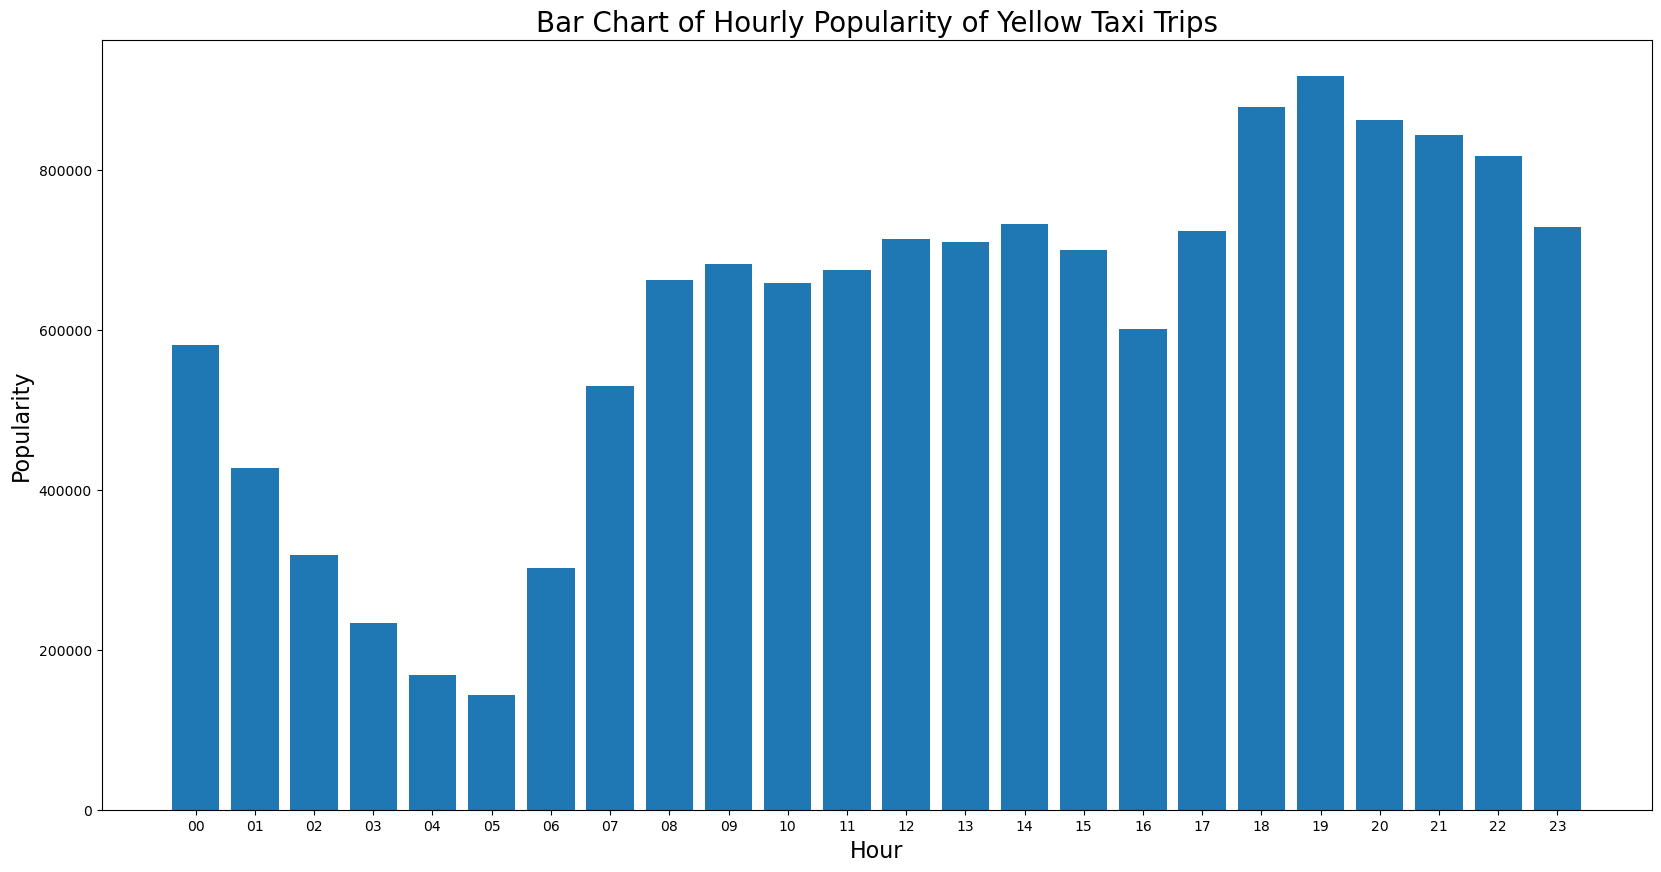

In [35]:
df1 = get_data_for_visual_1()
plot_barchart_visual_1(df1)

## Visualization 2

In [36]:
def get_data_for_visual_2():
    visual_query_2 = """
    WITH RECURSIVE monthlytrips AS ( 
        SELECT strftime("%m", start_datetime) AS month, distance FROM ubertrips
            UNION ALL
        SELECT strftime("%m", start_datetime) AS month, distance FROM taxitrips
    )
    SELECT month, avg(distance) AS avg_distance FROM monthlytrips
    GROUP BY month
    ORDER BY month ASC
    """
    return pd.read_sql_query(visual_query_2, con=connection)

In [37]:
def plot_confbands_visual_2(dataframe):
    dataframe.sort_values(by=["month"], inplace=True, ascending=True)
    x = dataframe["month"].astype(int).values
    y = dataframe["avg_distance"].values
    
    a, b = np.polyfit(x, y, deg=1)
    y_est = a * x + b
    y_err = 1.796 * x.std() * np.sqrt( 1/len(x)+(x - x.mean())**2 / np.sum((x - x.mean())**2))

    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(x, y_est, '-')
    ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
    ax.plot(x, y, 'o', color='tab:brown')
    ax.set_xlabel("Month", fontsize=16)
    ax.set_ylabel("AvgDistance", fontsize=16)
    ax.set_title("Plot of Monthly Average Distance of All Trips(With 90% Confidence Bands)", fontsize=20)
    
    plt.show()

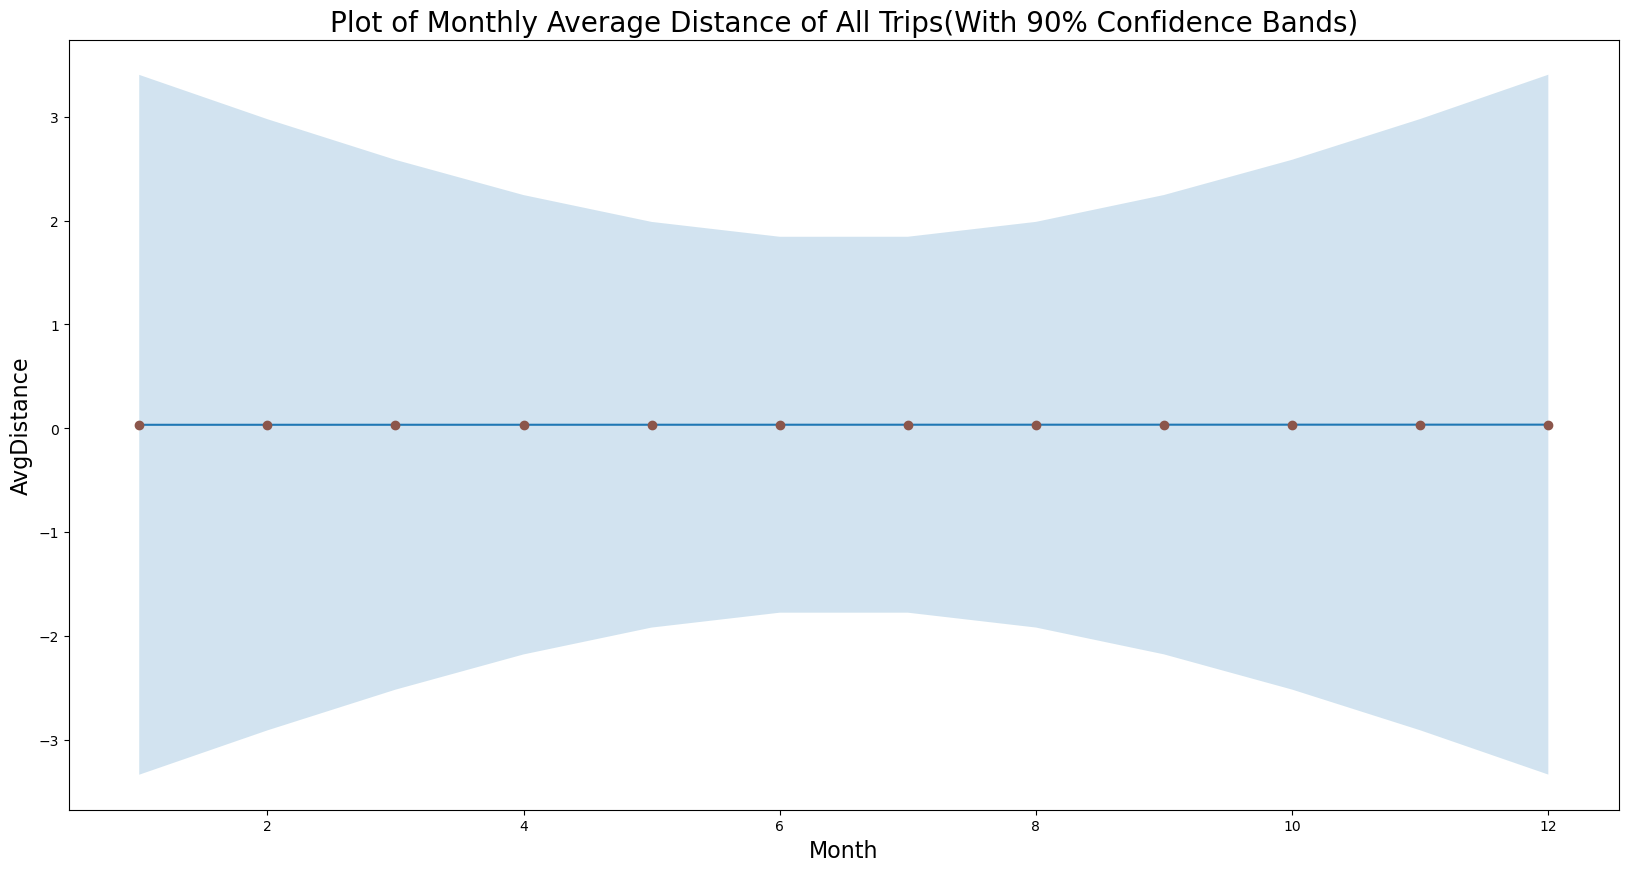

In [38]:
df2 = get_data_for_visual_2()
plot_confbands_visual_2(df2)